In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import dotenv
import huggingface_hub
import torch
import transformers
import time

_ = dotenv.load_dotenv(dotenv_path=".env", override=True)
huggingface_hub.login(token=os.environ["HF_TOKEN"])

model_name = "google/gemma-3-1b-it"
local_path = "./models"
os.makedirs(local_path, exist_ok=True)

start_time = time.time()
model = transformers.AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_name,
    token=os.environ["HF_TOKEN"],
    device_map="auto", dtype=torch.bfloat16
)
model.save_pretrained(save_directory=local_path)

tokenizer = transformers.AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path=model_name,
    token=os.environ["HF_TOKEN"]
)
tokenizer.save_pretrained(save_directory=local_path)
end_time = time.time() - start_time

print("Time taken: %.2f"%(end_time))

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Time taken: 266.67


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import langchain_huggingface

local_dir = "./models"
llm = langchain_huggingface.HuggingFacePipeline.from_model_id(
    task="text-generation", model_id=local_dir,
    pipeline_kwargs={"max_new_tokens": 512, "temperature": 0.1})
llm = langchain_huggingface.ChatHuggingFace(llm=llm)

## Customer Review

In [2]:
from langchain_core import prompts
from typing import TypedDict
from langgraph import graph
import time

review_template = """
For the following text, extract the following information:

gift: Was the item purchased as a gift for someone else?
Answer True if yes, False if not or unknown.

delivery_days: How many days did it take for the product
to arrive? If this information is not found, output -1.

price_value: Extract any sentences about the value or price,
and output them as a comma separated Python list.

Format the output as JSON with the following keys:
gift
delivery_days
price_value

text: {text}
"""

customer_review = """
This leaf blower is pretty amazing.  It has four settings:
candle blower, gentle breeze, windy city, and tornado. It
arrived in two days, just in time for my wife's anniversary
present. I think my wife liked it so much she was speechless. So
far I've been the only one using it, and I've been using it
every other morning to clear the leaves on our lawn. It's
slightly more expensive than the other leaf blowers out there,
but I think it's worth it for the extra features.
"""

prompt_template = prompts.PromptTemplate.from_template(template=review_template)
chain = prompt_template | llm.bind(skip_prompt=True)

class GraphState(TypedDict):
    text: str
    response: dict

def review_node(state: GraphState):
    response = chain.invoke(input={"text": state["text"]})
    return {"response": response}

workflow = graph.StateGraph(state_schema=GraphState)
workflow.add_node(node="review", action=review_node)
workflow.add_edge(start_key=graph.START, end_key="review")
workflow.add_edge(start_key="review", end_key=graph.END)
agents = workflow.compile()

start_time = time.time()
review_response = agents.invoke(input={"text": customer_review})
end_time = time.time() - start_time
print("Duration: %.2f, Response: %s"%(end_time, review_response["response"].content))

Duration: 30.88, Response: ```json
{
  "gift": true,
  "delivery_days": "2",
  "price_value": "leaf blower"
}
```


## Langgraph

In [2]:
# Define tools
from langchain import tools

@tools.tool
def multiply(a: int, b: int) -> int:
    """
    Multiply `a` and `b`.
    Args:
        a: First int
        b: Second int
    """
    return a * b

@tools.tool
def add(a: int, b: int) -> int:
    """
    Adds `a` and `b`.
    Args:
        a: First int
        b: Second int
    """
    return a + b

@tools.tool
def divide(a: int, b: int) -> float:
    """
    Divide `a` and `b`.
    Args:
        a: First int
        b: Second int
    """
    return a / b

tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools=tools)

In [3]:
# Define state
import typing
from langchain import messages
import operator

class MessagesState(typing.TypedDict):
    messages: typing.Annotated[list[messages.AnyMessage], operator.add]
    llm_calls: int

In [4]:
# Define llm node
from langchain import messages

def llm_call(state: dict):
    """
    LLM decides whether to call a tool or not.
    """
    return {
        "messages": [
            llm_with_tools.invoke(input=[
                messages.SystemMessage(content="""
                    You're a helpful assistant tasked with performing arithmetic
                    on a set of inputs.
                """)
            ] + state["messages"])
        ],
        "llm_calls": state.get("llm_calls", 0) + 1
    }

In [5]:
# Define tool node
from langchain import messages

def tool_node(state: dict):
    """
    Performs the tool call.
    """
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call]["name"]
        observation = tool.invoke(input=tool_call["args"])
        result.append(messages.ToolMessage(content=observation, tool_call_id=tool_cal["id"]))
    return {"messages": result}

In [6]:
# Define end logic
import typing
from langgraph import graph

def should_continue(state: MessagesState) -> typing.Literal["tool_node", graph.END]:
    """
    Decide if we should continue the loop or stop based upon whether the LLM
    made a tool call.
    """
    last_message = state["messages"][-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we stop (reply to the user)
    return graph.END

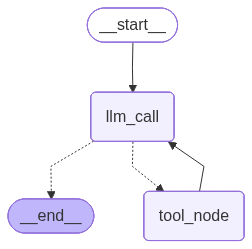

================================ Human Message =================================


            Add 34 and 79, then divide the number by 3.
        
================================== Ai Message ==================================

<bos><start_of_turn>user

                    You're a helpful assistant tasked with performing arithmetic
                    on a set of inputs.
                

Add 34 and 79, then divide the number by 3.<end_of_turn>
<start_of_turn>model
Okay, let's do that!

1.  34 + 79 = 113
2.  113 / 3 = 37.666...

Therefore, the answer is approximately **37.67** (rounded to two decimal places).


In [7]:
# Build workflow and compile agent
from langgraph import graph
from langchain import messages

# Build workflow
workflow = graph.StateGraph(state_schema=MessagesState)

# Add nodes
workflow.add_node(node="llm_call", action=llm_call)
workflow.add_node(node="tool_node", action=tool_node)

# Add edges
workflow.add_edge(start_key=graph.START, end_key="llm_call")
workflow.add_conditional_edges(
    source="llm_call",
    path=should_continue,
    path_map=["tool_node", graph.END]
)
workflow.add_edge(start_key="tool_node", end_key="llm_call")

# Compile agent
agent = workflow.compile()

# Show the agent
from IPython import display
display.display(display.Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
response = agent.invoke(input={
    "messages" : [
        messages.HumanMessage(content="""
            Add 34 and 79, then divide the number by 3.
        """)]
})
for m in response["messages"]:
    m.pretty_print()

In [8]:
response

{'messages': [HumanMessage(content='\n            Add 34 and 79, then divide the number by 3.\n        ', additional_kwargs={}, response_metadata={}),
  AIMessage(content="<bos><start_of_turn>user\n\n                    You're a helpful assistant tasked with performing arithmetic\n                    on a set of inputs.\n                \n\nAdd 34 and 79, then divide the number by 3.<end_of_turn>\n<start_of_turn>model\nOkay, let's do that!\n\n1.  34 + 79 = 113\n2.  113 / 3 = 37.666...\n\nTherefore, the answer is approximately **37.67** (rounded to two decimal places).", additional_kwargs={}, response_metadata={}, id='lc_run--019bcca2-ce4f-7ef3-8130-827f9b1a0aad-0', tool_calls=[], invalid_tool_calls=[])],
 'llm_calls': 1}

In [6]:
%%bash
pip install --no-cache-dir -qU \
    wikipedia

In [ ]:
# Define wikipedia tools
from langchain import tools
import wikipedia

@tools.tool
def wikipedia_tool(
    query: str
):
    """
    Use `query` to search Wikipedia for factual information.
    Args:
        query: str
    """
    try:
        title = wikipedia.search(query)[0]
        if not title:
            return "No results found on Wikipedia."
        summary = wikipedia.summary(title=title, sentences=5, auto_suggest=False,
            redirect=True)
    except Exception as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Wikipedia summary: {summary}"

summary = wikipedia_tool.invoke(input={"query": "SWIFT"})
print(summary)